1560114
True
1263165
reviews    1
label      0
dtype: int64
Train Reviews :  1010532
Test_Reviews :  252633
   label   count
0      0  493583
1      1  516949
`analyze` requires a `str` or an iterable of `str` parameters.
train finished
test finished
126516
Size of Vocabulary : 126516
등장빈도가 1번 이하인 희귀 단어의 수 : 81314
단어 집합에서 희귀 단어의 비율 :  64.27171266875335
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.2756179759945871
단어 집합의 크기 :  45204
7895/7895 [==============================] - 82s 10ms/step - loss: 0.4994 - acc: 0.7421
테스트 정확도 : 0.7421


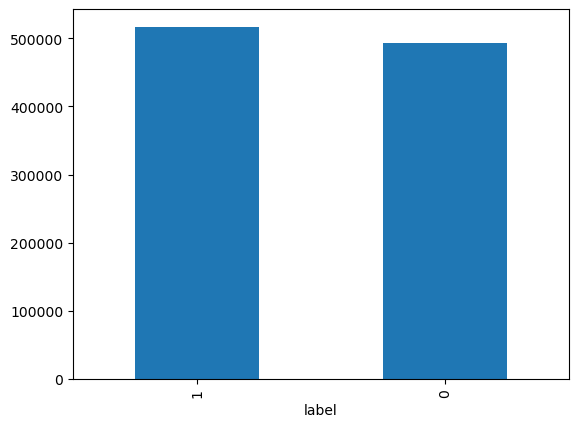

In [4]:
import time

from INSTA_PACKAGE.instaloader import *
import shutil
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import urllib.request
from kiwipiepy import Kiwi
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

# CSV 파일을 읽어 데이터프레임 생성, 열 이름 설정, 데이터프레임의 길이 출력, 데이터프레임의 처음 몇 행 출력

df = pd.read_csv("/Users/sun/PycharmProjects/EmotionAnalysis_SNS_v2/Json_PreProcessing/CSV_DATA/merged_file_v1.csv", sep="\t", header=None, encoding="utf-8-sig")
df.columns = ['reviews', 'label']
print(len(df))
df.head()
# 중복 리뷰를 삭제하고, NaN 값 확인 및 데이터프레임 길이 출력
df.drop_duplicates(subset=['reviews'], inplace=True)
print(df.isnull().values.any())
print(len(df))

# 리뷰 텍스트에서 한글 문자 이외의 문자를 삭제하고, 빈 문자열을 NaN으로 대체하며, NaN 값 개수 출력
df['reviews'] = df['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")
df['reviews'].replace('', np.nan, inplace=True)
print(df.isnull().sum())
# 데이터를 학습 데이터와 테스트 데이터로 분할하고 데이터 개수 출력
train_data, test_data = train_test_split(df, test_size=0.2, random_state=97)
print("Train Reviews : ", len(train_data))
print("Test_Reviews : ", len(test_data))

# 학습 데이터의 레이블 분포를 막대 그래프로 표시하고, 레이블별 데이터 개수 출력
train_data['label'].value_counts().plot(kind='bar')
# print(train_data.groupby('label').size().reset_index(name='count'))

# Kiwi 객체 생성 및 불용어(stopwords) 정의
# Kiwi 한국어 형태소 분석기 라이브러리 사용
kiwi = Kiwi()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지',
			 '임', '게']

# 문장을 토큰화하는 함수 정의
def tokenizing(sentence):
	try:
		if not sentence:
			raise ValueError
		words = []  # 변수를 초기화
		tokens = kiwi.tokenize(sentence)
		for token in tokens:
			if token[0] not in stopwords:
				words.append(token[0])
	except ValueError as e:
		print(e)

	return words

# 학습 데이터와 테스트 데이터에 토큰화 함수 적용
train_data['tokenized'] = train_data['reviews'].apply(tokenizing)
print("train finished")
test_data['tokenized'] = test_data['reviews'].apply(tokenizing)
print("test finished")

# 학습 데이터와 테스트 데이터의 토큰화된 리뷰 및 레이블을 추출
X_train = train_data['tokenized'].values
Y_train = train_data['label'].values
X_test = test_data['tokenized'].values
Y_test = test_data['label'].values

# Tokenizer 객체를 생성하고 학습 데이터로 텍스트 토큰화 모델을 학습
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# 단어 인덱스의 총 개수 출력
# print(len(tokenizer.word_index))

# 희귀 단어를 정의하는 등장 빈도 임계값 설정
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어 등장 빈도 계산
for key, value in tokenizer.word_counts.items():
	total_freq = total_freq + value

	if value < threshold:
		rare_cnt += 1
		rare_freq = rare_freq + value

# 어휘 크기, 희귀 단어 수, 희귀 단어 비율, 희귀 단어 등장 빈도 비율 출력
# print("Size of Vocabulary :", total_cnt)
# print(f'등장빈도가 {threshold - 1}번 이하인 희귀 단어의 수 : {rare_cnt}')
# print("단어 집합에서 희귀 단어의 비율 : ", (rare_cnt / total_cnt) * 100)
# print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq / total_freq) * 100)

# 어휘 크기를 희귀 단어 수를 제외한 값으로 정의
vocab_size = total_cnt - rare_cnt + 2
# print('단어 집합의 크기 : ', vocab_size)

# 정수 인코딩 과정에서 vocab_size 보다 큰 숫자가 부여된 단어들은 OOV로 변환
# Out Of Vocabulary
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
max_len = 75
# 훈련 및 테스트 데이터를 특정 길이(max_len)로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#모델 로딩 및 평가
loaded_model = load_model('activity_distinction_2.h5')
print('테스트 정확도 : %.4f' % (loaded_model.evaluate(X_test, Y_test)[1]))


#문장 감정 예측 함수
def sentiment_predict(new_sentence: str):
	new_sentence = re.sub('r[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', new_sentence)
	new_sentence = tokenizing(new_sentence)
	encoded = tokenizer.texts_to_sequences([new_sentence])
	pad_new = pad_sequences(encoded, maxlen=max_len)
	score = float(loaded_model.predict(pad_new))

	if score > 0.5:
		print("{:.2f}% 확률로 활동성 리뷰입니다.".format(score * 100))
	else:
		print("{:.2f}% 확률로 비활동성 리뷰입니다.".format((1 - score) * 100))

1560114
True
1263165
reviews    1
label      0
dtype: int64
Train Reviews :  1010532
Test_Reviews :  252633
`analyze` requires a `str` or an iterable of `str` parameters.
train finished
test finished
   1/7895 [..............................] - ETA: 19:33 - loss: 0.4818 - acc: 0.7188

2023-11-23 10:51:03.175571: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7895/7895 [==============================] - 74s 9ms/step - loss: 0.4994 - acc: 0.7421
테스트 정확도 : 0.7421
Retrieving posts from profile jiwom10.
[1/2] jiwom10/2023-11-15_06-56-10_UTC.jpg 
[2/2] jiwom10/2023-11-14_11-43-58_UTC.jpg 

SNS  ->  ['아 감기 걸렸나', '밖에 춥다 집에 누워서 유튜브나 봐야지...ㅋ'] 

아 감기 걸렸나
1/1 [==============================] - 0s 130ms/step
96.60% 확률로 비활동성 리뷰입니다.


밖에 춥다 집에 누워서 유튜브나 봐야지...ㅋ
1/1 [==============================] - 0s 8ms/step
56.26% 확률로 비활동성 리뷰입니다.




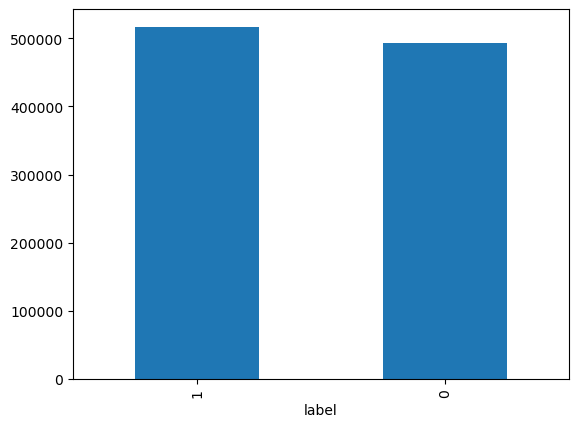

In [2]:
import time

from INSTA_PACKAGE.instaloader import *
import shutil
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import urllib.request
from kiwipiepy import Kiwi
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

# CSV 파일을 읽어 데이터프레임 생성, 열 이름 설정, 데이터프레임의 길이 출력, 데이터프레임의 처음 몇 행 출력

df = pd.read_csv("/Users/sun/PycharmProjects/EmotionAnalysis_SNS_v2/Json_PreProcessing/CSV_DATA/merged_file_v1.csv", sep="\t", header=None, encoding="utf-8-sig")
df.columns = ['reviews', 'label']
print(len(df))
df.head()
# 중복 리뷰를 삭제하고, NaN 값 확인 및 데이터프레임 길이 출력
df.drop_duplicates(subset=['reviews'], inplace=True)
print(df.isnull().values.any())
print(len(df))

# 리뷰 텍스트에서 한글 문자 이외의 문자를 삭제하고, 빈 문자열을 NaN으로 대체하며, NaN 값 개수 출력
df['reviews'] = df['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")
df['reviews'].replace('', np.nan, inplace=True)
print(df.isnull().sum())
# 데이터를 학습 데이터와 테스트 데이터로 분할하고 데이터 개수 출력
train_data, test_data = train_test_split(df, test_size=0.2, random_state=97)
print("Train Reviews : ", len(train_data))
print("Test_Reviews : ", len(test_data))

# 학습 데이터의 레이블 분포를 막대 그래프로 표시하고, 레이블별 데이터 개수 출력
train_data['label'].value_counts().plot(kind='bar')
# print(train_data.groupby('label').size().reset_index(name='count'))

# Kiwi 객체 생성 및 불용어(stopwords) 정의
# Kiwi 한국어 형태소 분석기 라이브러리 사용
kiwi = Kiwi()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지',
			 '임', '게']

# 문장을 토큰화하는 함수 정의
def tokenizing(sentence):
	try:
		if not sentence:
			raise ValueError
		words = []  # 변수를 초기화
		tokens = kiwi.tokenize(sentence)
		for token in tokens:
			if token[0] not in stopwords:
				words.append(token[0])
	except ValueError as e:
		print(e)

	return words

# 학습 데이터와 테스트 데이터에 토큰화 함수 적용
train_data['tokenized'] = train_data['reviews'].apply(tokenizing)
print("train finished")
test_data['tokenized'] = test_data['reviews'].apply(tokenizing)
print("test finished")

# 학습 데이터와 테스트 데이터의 토큰화된 리뷰 및 레이블을 추출
X_train = train_data['tokenized'].values
Y_train = train_data['label'].values
X_test = test_data['tokenized'].values
Y_test = test_data['label'].values

# Tokenizer 객체를 생성하고 학습 데이터로 텍스트 토큰화 모델을 학습
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# 단어 인덱스의 총 개수 출력
# print(len(tokenizer.word_index))

# 희귀 단어를 정의하는 등장 빈도 임계값 설정
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어 등장 빈도 계산
for key, value in tokenizer.word_counts.items():
	total_freq = total_freq + value

	if value < threshold:
		rare_cnt += 1
		rare_freq = rare_freq + value

# 어휘 크기, 희귀 단어 수, 희귀 단어 비율, 희귀 단어 등장 빈도 비율 출력
# print("Size of Vocabulary :", total_cnt)
# print(f'등장빈도가 {threshold - 1}번 이하인 희귀 단어의 수 : {rare_cnt}')
# print("단어 집합에서 희귀 단어의 비율 : ", (rare_cnt / total_cnt) * 100)
# print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq / total_freq) * 100)

# 어휘 크기를 희귀 단어 수를 제외한 값으로 정의
vocab_size = total_cnt - rare_cnt + 2
# print('단어 집합의 크기 : ', vocab_size)

# 정수 인코딩 과정에서 vocab_size 보다 큰 숫자가 부여된 단어들은 OOV로 변환
# Out Of Vocabulary
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
max_len = 75
# 훈련 및 테스트 데이터를 특정 길이(max_len)로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#모델 로딩 및 평가
loaded_model = load_model('activity_distinction_2.h5')
print('테스트 정확도 : %.4f' % (loaded_model.evaluate(X_test, Y_test)[1]))


#문장 감정 예측 함수
def sentiment_predict(new_sentence: str):
	new_sentence = re.sub('r[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', new_sentence)
	new_sentence = tokenizing(new_sentence)
	encoded = tokenizer.texts_to_sequences([new_sentence])
	pad_new = pad_sequences(encoded, maxlen=max_len)
	score = float(loaded_model.predict(pad_new))

	if score > 0.5:
		print("{:.2f}% 확률로 활동성 리뷰입니다.".format(score * 100))
	else:
		print("{:.2f}% 확률로 비활동성 리뷰입니다.".format((1 - score) * 100))

import time
##########################################
txt_list = []
instance = instaloader.Instaloader()
insta_name = str(input("인스타 사용자 이름 입력 -> "))
instance.download_profile(profile_name=insta_name, max_count=5, txt_list=txt_list)
print("\nSNS  -> ",txt_list,"\n")
shutil.rmtree(insta_name)

time.sleep(1)
for i in txt_list:
	print(i)
	sentiment_predict(i),print('\n')
#######################################